## SENG 474 Data Mining Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


data = pd.read_csv('google-play-store-apps/googleplaystore.csv')
#wait like 30s for this to finish
to_drop = ['Size',
          'Last Updated',
          'Current Ver',
          'Android Ver']
data.drop(to_drop, inplace=True, axis=1)
data.head()


,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,"10,000+",Free,0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967,"500,000+",Free,0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,"5,000,000+",Free,0,Everyone,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,"50,000,000+",Free,0,Teen,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,"100,000+",Free,0,Everyone,Art & Design;Creativity


In [2]:
def clean_data(data):
    # Fixing Price
    data = data.where(data['Price'] != "Everyone")
    data["Price"] = data["Price"].str.replace("$", '')
    data["Price"] = pd.to_numeric(data["Price"])

    # Fixing Installs
    data["Installs"] = data["Installs"].str.replace(",", '')
    data["Installs"] = data["Installs"].str.replace("+", '')
    data["Installs"] = pd.to_numeric(data["Installs"])

    data["Reviews"] = pd.to_numeric(data["Reviews"])
    data['Genres'] = data['Genres'].fillna('')
    
    data = data.dropna()
    return data

data = clean_data(data)
data.head()

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,10000.0,Free,0.0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,5000000.0,Free,0.0,Everyone,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,50000000.0,Free,0.0,Teen,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,100000.0,Free,0.0,Everyone,Art & Design;Creativity


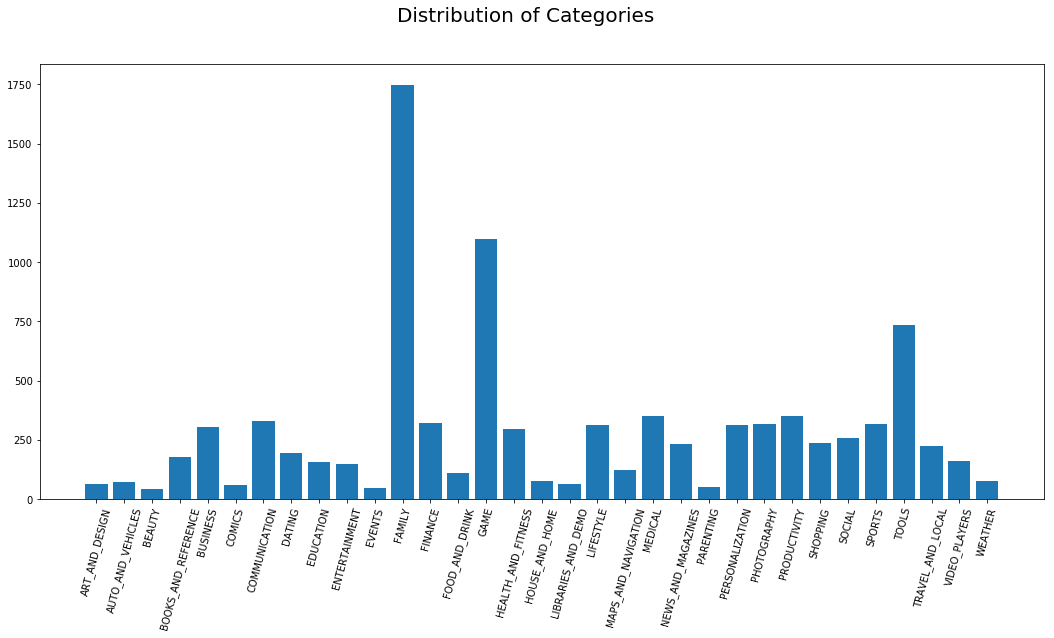

In [3]:
def count_unique(col):
    unique, counts = np.unique(col, return_counts=True)
    return np.array(list(zip(unique, counts)), dtype=object)

X = data.values

def plot_bar(col, title, color=None):
    category = count_unique(col)
    fig, ax = plt.subplots(figsize=(18,8))
    y_pos = np.arange(len(category[:,0]))
    plt.bar(y_pos, category[:,1], color=color)
    plt.xticks(y_pos, category[:, 0])
    plt.xticks(rotation=75)
    fig.suptitle(title, fontsize=20)
    
def plot_pie(col, title, color=None):
    category = count_unique(col)
    fig, ax = plt.subplots(figsize=(18,8))
    plt.pie(category[:,1], autopct='%.2f%%', labels=category[:,0])
    fig.suptitle(title, fontsize=20)
    
plot_bar(X[:, 1], 'Distribution of Categories')

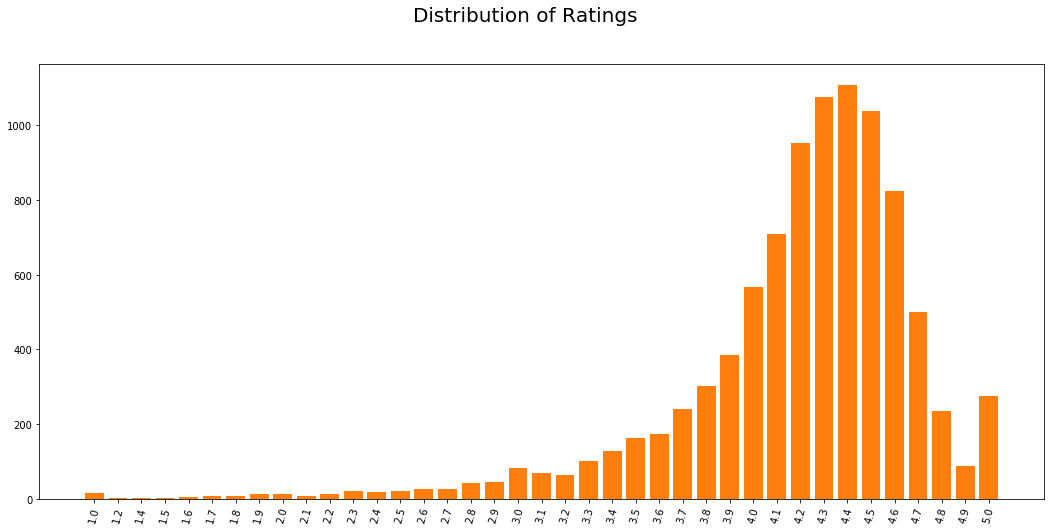

In [4]:
plot_bar(X[:, 2], 'Distribution of Ratings', 'C1')

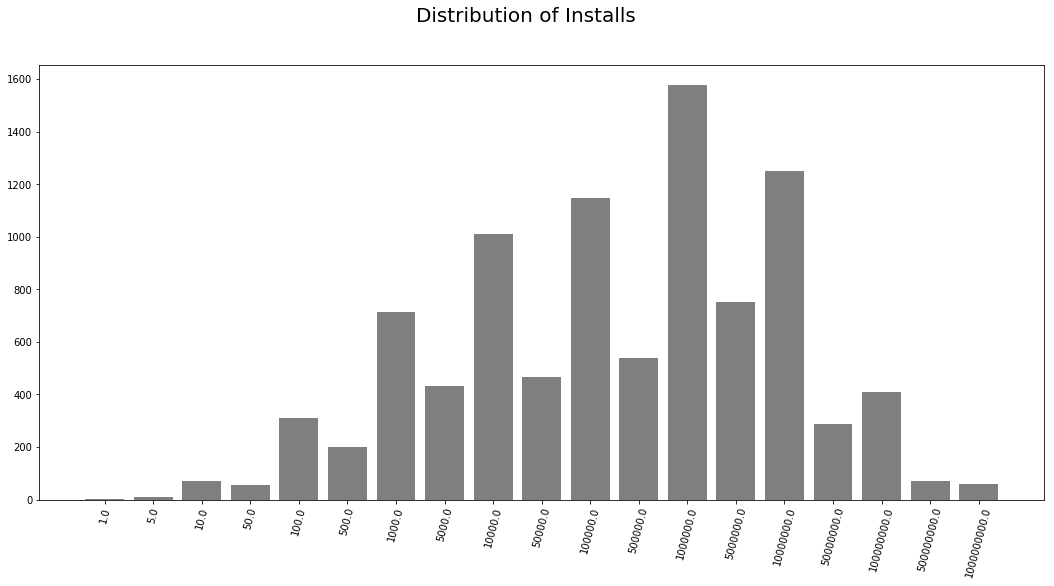

In [5]:
plot_bar(X[:, 4], 'Distribution of Installs', 'C7')

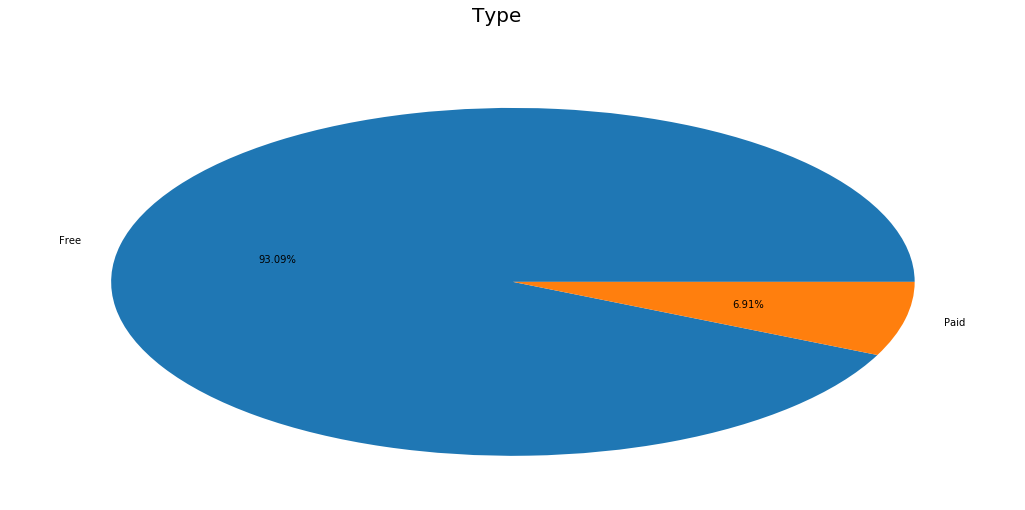

In [6]:
plot_pie(X[:, 5], 'Type', 'C2')

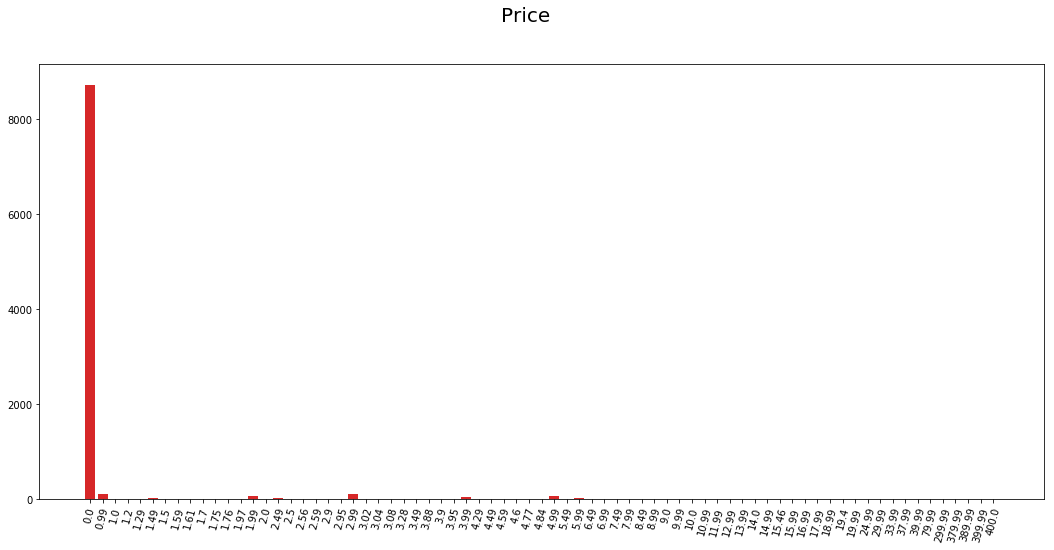

In [7]:
plot_bar(X[:, 6], 'Price', 'C3')

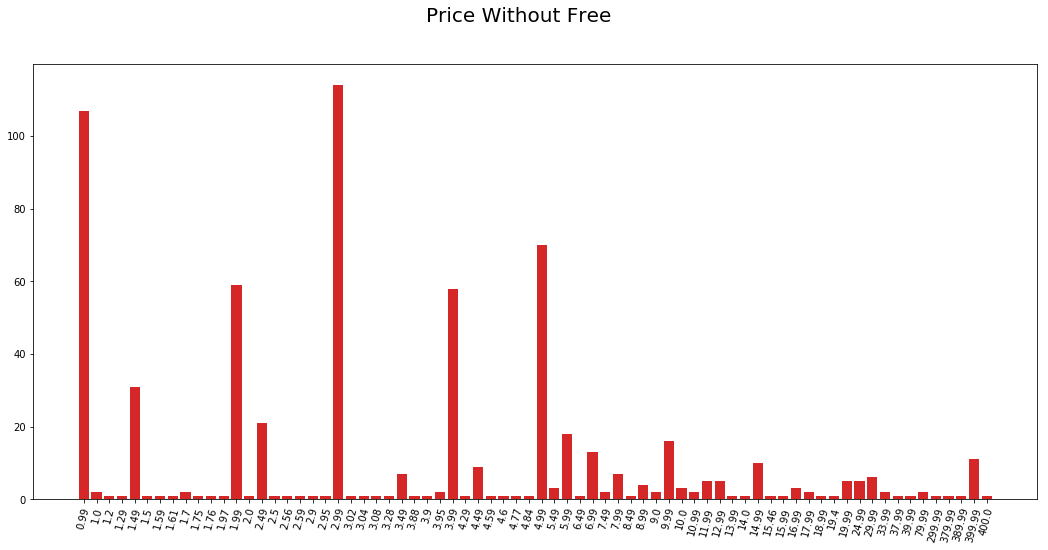

In [8]:
plot_bar(X[X[:, 6]>0][:, 6], 'Price Without Free', 'C3')

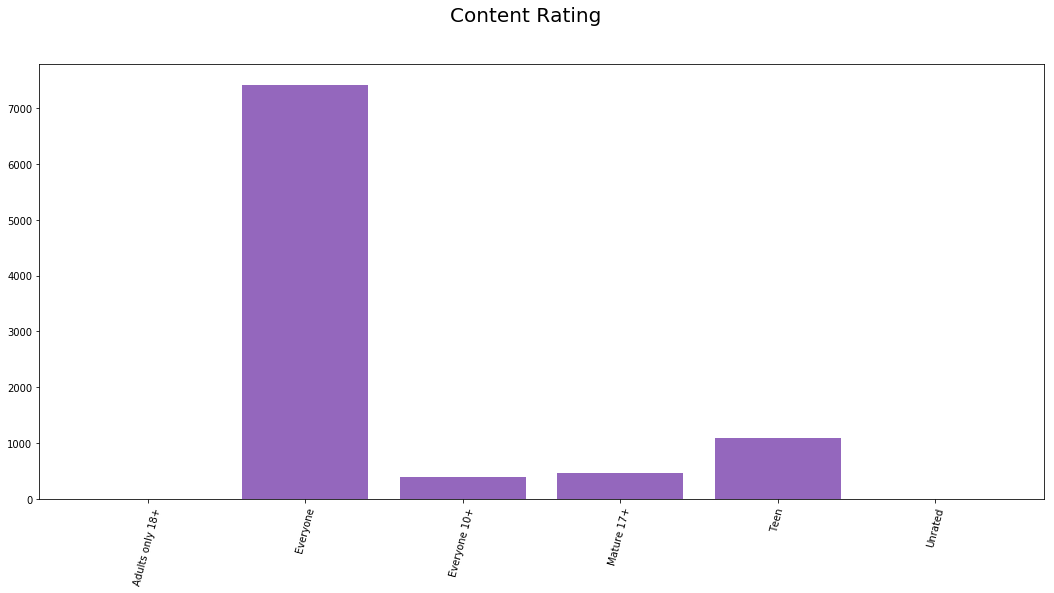

In [9]:
plot_bar(X[:, 7], 'Content Rating', 'C4')

In [10]:
def ranked_recommendations(recommended_data):
    C = recommended_data['Rating'].mean()
    print(C)

    # Calculate the minimum number of votes required to be in race (lower the more apps)
    m = recommended_data['Reviews'].quantile(0.10)
    print(m)

    # Filter out all qualified apps into a new DataFrame
    q_apps = recommended_data.copy().loc[data['Reviews'] >= m]
    q_apps.shape

    # Function that computes the weighted rating of each app
    def weighted_rating(x, m=m, C=C):
        v = x['Reviews']
        R = x['Rating']
        # Calculation based on the IMDB formula
        return (v/(v+m) * R) + (m/(m+v) * C)

    # Define a new feature 'score' and calculate its value with `weighted_rating()`
    q_apps['score'] = q_apps.apply(weighted_rating, axis=1)

    q_apps = q_apps.sort_values('score', ascending=False)

    return q_apps


# GENRE BASED RECOMMENDER
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(data['Genres'])

tfidf_matrix.shape
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

# We now have a pairwise cosine similarity matrix for all the apps in our dataset. 
# The next step is to write a function that returns the 30 most similar apps based on the cosine similarity score.
data = data.reset_index()
indices = pd.Series(data.index, index=data['App'])

def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    new = data.iloc[movie_indices]
    return ranked_recommendations(new)

#  THESE RECOMMENDATIONS ARE BASED ON GENRES AND RANKED
get_recommendations('EC-HRV test').head(100)

4.453333333333333
30890.500000000004


,index,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,score
2826,2965,Onefootball - Soccer Scores,SPORTS,4.7,911995.0,10000000.0,Free,0.0,Everyone,Sports,4.691919
2835,2974,FotMob - Live Soccer Scores,SPORTS,4.7,410384.0,10000000.0,Free,0.0,Everyone,Sports,4.682733
1820,1902,Dream League Soccer 2018,GAME,4.6,9883806.0,100000000.0,Free,0.0,Everyone,Sports,4.599543
1657,1739,Dream League Soccer 2018,GAME,4.6,9882639.0,100000000.0,Free,0.0,Everyone,Sports,4.599543
1815,1897,Score! Hero,GAME,4.6,5419676.0,100000000.0,Free,0.0,Everyone,Sports,4.599169
1922,2004,Score! Hero,GAME,4.6,5419676.0,100000000.0,Free,0.0,Everyone,Sports,4.599169
1627,1709,Score! Hero,GAME,4.6,5418675.0,100000000.0,Free,0.0,Everyone,Sports,4.599169
2832,2971,Pro 2018 - Series A and B,SPORTS,4.6,101455.0,5000000.0,Free,0.0,Everyone,Sports,4.565767
1729,1811,MLB TAP SPORTS BASEBALL 2018,GAME,4.6,32506.0,1000000.0,Free,0.0,Everyone,Sports,4.528535
1789,1871,8 Ball Pool,GAME,4.5,14201891.0,100000000.0,Free,0.0,Everyone,Sports,4.499899
